In [15]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import xgboost as xgb
import bisect

from scipy import stats
from tqdm import tqdm
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN

In [51]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\train.csv').drop(['X1'], axis = 1)
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\test.csv').drop(['Id', 'X1'], axis = 1)

display(train.head())
display(test.head())

,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,56.3,67.5,22.5,AH32,4,97,PL973,467,2241
1,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163
2,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094
3,52.1,97.4,15.0,A,17,24,PL242,391,2604
4,42.9,58.7,14.5,A,4,23,PL233,232,1564


,X2,X3,X4,X5,X6,X7,X8
0,80.6,104.8,11.0,A,29,23,PL234
1,141.8,34.2,17.5,A,2,91,PL911
2,77.2,103.3,17.0,A,10,97,PL973
3,95.5,131.0,18.0,A,2,23,PL234
4,91.7,36.1,19.0,AH32,1,27,PL271


| 항목 | 설명     |
|-----|----------|
| X1  | 작업번호 |
| X2  | 마킹길이 |
| X3  | 절단길이 |
| X4  | 철판두께 |
| X5  | 철판재질 |
| X6  | 절단갯수 |
| X7  | 작업장   |
| X8  | 작업자   |
| Y1  | 마킹시간 |
| Y2  | 절단시간 |

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121754 entries, 0 to 121753
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X2      121754 non-null  float64
 1   X3      121754 non-null  float64
 2   X4      121754 non-null  float64
 3   X5      121754 non-null  object 
 4   X6      121754 non-null  int64  
 5   X7      121754 non-null  int64  
 6   X8      121754 non-null  object 
 7   Y1      121754 non-null  int64  
 8   Y2      121754 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 8.4+ MB


In [4]:
train.describe()

,X2,X3,X4,X6,X7,Y1,Y2
count,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,1.217540e+05,121754.000000
mean,77.608615,73.875636,17.444897,13.630049,43.921152,8.971671e+02,2193.206638
std,48.006125,53.267359,4.498316,20.751914,32.509414,4.604704e+04,2299.585390
min,3.200000,1.800000,6.000000,1.000000,14.000000,0.000000e+00,0.000000
25%,45.200000,40.900000,14.500000,1.000000,22.000000,2.380000e+02,1064.000000
50%,68.100000,52.800000,17.000000,4.000000,25.000000,3.790000e+02,1593.000000
75%,98.300000,93.000000,20.000000,18.000000,91.000000,5.480000e+02,2778.000000
max,524.400000,621.300000,40.000000,416.000000,97.000000,6.157364e+06,348262.000000


# 특징 만들기


In [17]:
mmtime = train.groupby('X5')['Y1'].mean()
mctime = train.groupby('X5')['Y2'].mean()

wmtime = train.groupby('X7')['Y1'].mean()
wctime = train.groupby('X7')['Y2'].mean()

manmtime = train.groupby('X8')['Y1'].mean()
manctime = train.groupby('X8')['Y2'].mean()

train['X5_mmtime'] = train['X5'].map(mmtime)
train['X5_mctime'] = train['X5'].map(mctime)

train['X7_wmtime'] = train['X7'].map(wmtime)
train['X7_wctime'] = train['X7'].map(wctime)

train['X8_manmtime'] = train['X8'].map(manmtime)
train['X8_manctime'] = train['X8'].map(manctime)

test['X5_mmtime'] = test['X5'].map(mmtime)
test['X5_mctime'] = test['X5'].map(mctime)

test['X7_wmtime'] = test['X7'].map(wmtime)
test['X7_wctime'] = test['X7'].map(wctime)

test['X8_manmtime'] = test['X8'].map(manmtime)
test['X8_manctime'] = test['X8'].map(manctime)

In [18]:
train

,X2,X3,X4,X5,X6,X7,X8,Y1,Y2,X5_mmtime,X5_mctime,X7_wmtime,X7_wctime,X8_manmtime,X8_manctime
0,56.3,67.5,22.5,AH32,4,97,PL973,467,2241,588.517493,2255.398250,424.774954,2635.545978,414.072878,2632.468069
1,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163,588.517493,2255.398250,512.662090,1440.456061,590.812157,1489.384339
2,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094,314.389561,1561.396820,304.917220,1160.583795,298.877326,1162.634690
3,52.1,97.4,15.0,A,17,24,PL242,391,2604,951.562925,2206.966183,538.719053,2867.222400,546.286353,2992.967657
4,42.9,58.7,14.5,A,4,23,PL233,232,1564,951.562925,2206.966183,406.549153,3019.517627,385.282033,2913.487235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121749,98.4,89.5,10.0,AE,8,21,PS213,906,1226,906.000000,1226.000000,568.374486,2918.445885,531.624726,2584.399671
121750,48.0,51.0,23.0,LAH36,1,23,PL231,175,1540,175.000000,1540.000000,406.549153,3019.517627,441.762766,3215.477385
121751,42.5,30.2,34.0,EH36,5,27,PL272,376,1492,376.000000,1492.000000,512.662090,1440.456061,585.325622,1431.167574
121752,22.1,15.3,36.0,AH36TL,8,97,PL973,85,723,609.500000,3930.750000,424.774954,2635.545978,414.072878,2632.468069


In [6]:
import re

def convert_x5(value):
    # -TM 이 포함되어 있으면 제거하고 숫자로 변환, 그렇지 않으면 그냥 숫자로 변환
    if '-TM' in value:
        value = value.replace('-TM', '')
    match = re.search(r'\d+', value)  # 정규표현식을 사용하여 숫자 추출
    if match:
        return int(match.group()) * 9.8
    else:
        return 235  # 숫자가 없는 경우 235로 설정

# X5 열에 변환 함수 적용
train['X5_numeric'] = train['X5'].apply(convert_x5)
test['X5_numeric'] = test['X5'].apply(convert_x5)

train.drop(columns = ['X5'], inplace = True)
test.drop(columns = ['X5'], inplace = True)

In [7]:
train['X2/X3'] = train['X2'] / train['X3']
test['X2/X3'] = test['X2'] / test['X3']

In [8]:
train['SPT'] = train['X5_numeric'] / train['X4']
test['SPT'] = test['X5_numeric'] / test['X4']

In [9]:
train['SPTCC'] = train['SPT'] * train['X6']
test['SPTCC'] = test['SPT'] * test['X6']

In [19]:
X2_idx = train[(train['X2'] > 440)].index # 440
X3_idx = train[(train['X3'] > 550)].index # 550
X4_idx = train[(train['X4'] > 36)].index
X6_idx = train[(train['X6'] > 250)].index # 250
Y1_idx = train[(train['Y1'] == 0) | (train['Y1'] > 70000)].index
Y2_idx = train[(train['Y2'] == 0) | (train['Y2'] > 70000)].index

train.loc[X2_idx, 'X2'] = train.loc[(train ['X2'] >= 500), 'X2'].mean()
train.loc[X3_idx, 'X3'] = train.loc[(train ['X3'] >= 600), 'X3'].mean()
train.loc[X4_idx, 'X4'] = train.loc[(train ['X4'] >= 36), 'X4'].mean()
train.loc[X6_idx, 'X6'] = train.loc[(train ['X6'] >= 265), 'X6'].mean()
train.loc[Y1_idx, 'Y1'] = train.loc[(train['Y1'] != 0) & (train['Y1'] <= 70000), 'Y1'].mean()
train.loc[Y2_idx, 'Y2'] = train.loc[(train['Y2'] != 0) & (train['Y2'] <= 70000), 'Y2'].mean()

In [27]:
# train['Y3'] = train['Y1'] + train['Y2']
# Q1_Y3 = train['Y3'].quantile(0.25)
# Q3_Y3 = train['Y3'].quantile(0.75)

# IQR_Y3 = Q3_Y3 - Q1_Y3

# lower_bound_Y3 = Q1_Y3 - 1.5 * IQR_Y3
# upper_bound_Y3 = Q3_Y3 + 1.5 * IQR_Y3

# train = train[(train['Y3'] >= lower_bound_Y3) & (train['Y3'] <= upper_bound_Y3)]

# train.drop(columns = 'Y3', inplace = True)
# train

In [12]:
mttrain = train[['X2','X3','X8','Y1']]

mtdrop = mttrain[mttrain['Y1'] == 0].index
mttrain.drop(mtdrop, inplace = True)

mttest = test[['X2','X3','X8']]

C:\Users\dlwks\AppData\Local\Temp\ipykernel_18352\450819337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mttrain.drop(mtdrop, inplace = True)


In [13]:
scaler = MinMaxScaler()

mtscale = mttrain.copy()
mtscale[['X2','X3','Y1']] = scaler.fit_transform(mttrain[['X2','X3','Y1']])

In [ ]:
X2 = mtscale[['X2','Y1']].values
dbscan = DBSCAN(eps=0.01, min_samples=10).fit(X2)
mtscale['clusterX2'] = dbscan.fit_predict(mtscale[['X2','Y1']])
labels = dbscan.labels_
print(pd.Series(labels).value_counts())

In [ ]:
idx_X2 = mtscale[mtscale['clusterX2'] == -1].index

In [ ]:
X3 = mtscale[['X3','Y1']].values
dbscan = DBSCAN(eps=0.01, min_samples=10).fit(X3)
mtscale['clusterX3'] = dbscan.fit_predict(mtscale[['X3','Y1']])
labels = dbscan.labels_
print(pd.Series(labels).value_counts())

In [ ]:
idx_X3 = mtscale[mtscale['clusterX3'] == -1].index

In [ ]:
idx = idx_X2.append(idx_X3)
idx = set(idx)
mttrain.drop(idx , inplace=True)

In [ ]:
cttrain = train[['X3','X4', 'X5_mctime','X8_manctime','Y2']]

ctdrop = cttrain[cttrain['Y2'] == 0].index
cttrain.drop(mtdrop, inplace = True)

cttest = test[['X3','X4', 'X5_mctime','X8_manctime']]

In [ ]:
scaler = MinMaxScaler()

ctscale = cttrain.copy()
ctscale[['X3','Y2']] = scaler.fit_transform(cttrain[['X3','Y2']])

In [ ]:
X = ctscale[['X3','Y2']].values
dbscan = DBSCAN(eps=0.01, min_samples=15).fit(X)
ctscale['cluster'] = dbscan.fit_predict(ctscale[['X3','Y2']])
labels = dbscan.labels_
print(pd.Series(labels).value_counts())

In [ ]:
idx = ctscale[ctscale['cluster'] == -1].index
cttrain.drop(idx , inplace=True)

In [13]:
train['Y1'] = np.log1p(train['Y1'])
train['Y2'] = np.log1p(train['Y2'])

<Axes: >

<Axes: >

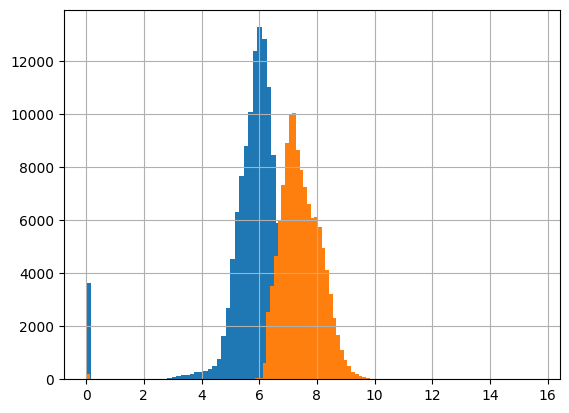

In [14]:
display(train['Y1'].hist(bins = 100))
display(train['Y2'].hist(bins = 100))

## CatBoost

In [21]:
class CustomPenaltyMetric(object):
    def get_final_error(self, error, weight):
        return error / len(weight)

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        penalty = 0
        for i in range(len(target)):
            pred = approxes[i]
            true = target[i]
            if pred < true:
                penalty += 0.1 * (true - pred)  # 예측값이 실제값보다 작을 때 10% 페널티
        return penalty, len(target)

# 사용자 정의 평가 지표를 CatBoost Metric으로 래핑
def custom_metric_wrapper(labels, preds):
    metric = CustomPenaltyMetric()
    return metric.evaluate(preds, labels, None)[0]

In [22]:
cat_y1 = CatBoostRegressor(eval_metric=custom_metric_wrapper,
                           cat_features=['X8'], 
                           verbose=50
                           )

X_train_reduced = train.drop(columns=['Y1', 'Y2']).reset_index(drop=True)
y_train = train['Y1'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    cat_y1.fit(X_t, y_t, eval_set=(X_val, y_val))

    val_pred = cat_y1.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    test = test[X_train_reduced.columns]

    cat_pred = cat_y1.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

final_predictions_y1 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

Learning rate set to 0.104496


CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/python-package/catboost/helpers.cpp:49: Traceback (most recent call last):
  File "_catboost.pyx", line 1334, in _catboost._MetricEval
AttributeError: 'function' object has no attribute 'evaluate'


In [ ]:
cat_y2 = CatBoostRegressor(loss_function=custom_metric_wrapper,
                           cat_features=['X8'], 
                           verbose=50
                           )

X_train_reduced = train.drop(columns=['Y1', 'Y2']).reset_index(drop=True)
y_train = train['Y2'].reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

ensemble_predictions = []
scores = []

y_train = y_train.values

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    cat_y2.fit(X_t, y_t, eval_set=(X_val, y_val))

    val_pred = cat_y2.predict(X_val)

    scores.append(mean_absolute_error(y_val, val_pred))

    cat_pred = cat_y2.predict(test)
    cat_pred = np.where(cat_pred < 0, 0, cat_pred)

    ensemble_predictions.append(cat_pred)

final_predictions_y2 = np.mean(ensemble_predictions, axis=0)

print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

## MLJAR

In [ ]:
!pip install mljar-supervised

In [ ]:
categorical_features = ['X8']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

In [ ]:
from supervised.automl import AutoML

train_x1 = train.drop(['Y1', 'Y2'], axis=1)
train_x2 = train.drop(['Y1', 'Y2'], axis=1)

train_y1 = train['Y1']
train_y2 = train['Y2']


Cross_validation = {
    "validation_type": "kfold",
    "k_folds": 10,
    "shuffle": True,
    "random_seed": 112
}

In [ ]:
automl_y1 = AutoML(mode="Compete", algorithms = ['Decision Tree', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, eval_metric='mae', validation_strategy=Cross_validation, ml_task = "regression",
                   total_time_limit = 1800 * 2 * 5)
automl_y1.fit(train_x1, train_y1)

In [ ]:
automl_y2 = AutoML(mode="Compete", algorithms = ['Decision Tree', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, eval_metric='mae', validation_strategy=Cross_validation, ml_task = "regression",
                   total_time_limit=1800 * 2 * 5)
automl_y2.fit(train_x2, train_y2)

In [ ]:
pred_y1 = automl_y1.predict_all(test)
pred_y2 = automl_y2.predict_all(test)

In [ ]:
final_predictions = (np.expm1(pred_y1)) + (np.expm1(pred_y2))

## 제출

In [ ]:
submit = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\sample_submission.csv')

submit.head()

In [ ]:
final_predictions = np.expm1(final_predictions_y1) + np.expm1(final_predictions_y2)

submit.iloc[:, 1] = final_predictions

submit

In [ ]:
submit.to_csv('C:\\Users\\dlwks\\OneDrive\\바탕 화면\\VSCode\\HD_CNC\\1129-1.csv', index=False)